## 🔎 Carga y EDA

In [609]:
# Importar librerías
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


In [610]:

df = pd.read_csv("StudentsPerformance_missing.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72.0,72,74.0
1,female,group C,some college,standard,completed,69.0,90,88.0
2,female,group B,master's degree,standard,none,90.0,95,93.0
3,male,group A,associate's degree,free/reduced,none,47.0,57,44.0
4,male,group C,some college,standard,none,76.0,78,75.0


In [611]:
# Verificar estadisticas de los datos, incluir categoricos
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,950,6,associate's degree,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,950.0,NaN,NaN,NaN,66.268421,14.916436,8.0,57.0,66.0,77.0,100.0
reading score,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing score,950.0,NaN,NaN,NaN,67.893684,15.188463,10.0,57.0,69.0,79.0,100.0


In [612]:
# Verificar si hay datos faltantes
df.isnull().sum()

gender                          0
race/ethnicity                  0
parental level of education    50
lunch                           0
test preparation course         0
math score                     50
reading score                   0
writing score                  50
dtype: int64

In [613]:
# Verificar los valores de las características categóricas
print('Race/Ethnicity: ', df["race/ethnicity"].unique())
print('Parental level of education: ', df["parental level of education"].unique())
print('Lunch: ', df["lunch"].unique())
print('Test preparation course: ', df["test preparation course"].unique())
print('Gender:', df["gender"].unique())

Race/Ethnicity:  ['group B' 'group C' 'group A' 'group D' 'group E']
Parental level of education:  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 nan 'high school' 'some high school']
Lunch:  ['standard' 'free/reduced']
Test preparation course:  ['none' 'completed']
Gender: ['female' 'male']


In [614]:
# Verificar si hay datos duplicados
df.duplicated().sum()

np.int64(0)

##  🛠️Parte 2: Preprocesamiento

### Imputación

In [615]:
## Imputación de datos faltantes

# Para la variable parental level of education usaremos la moda, pues al ser 50/1000 esperamos no crear valores atipicos
df.fillna({"parental level of education": df["parental level of education"].mode()[0]}, inplace=True)
# Como los valores math score y writing score son esenciales para que nuestro modelo prediga el rendimiento, eliminamos las filas con datos faltantes
df.dropna(subset=["math score", "writing score"], inplace=True)
# Verificamos que no haya datos faltantes
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

### Creación de la variable objetivo

In [616]:
# Crear una nueva columna "total score" que se calcule con el promedio de las tres notas y clasifique en:
# 1. Bajo: menos de 60
# 2. Medio: entre 60 y 85
# 3. Alto: más de 85
df["total score"] = (df["math score"] + df["reading score"] + df["writing score"]) / 3 
def classify_score(score):
    if score < 60:
        return "Bajo"
    elif 60 <= score <= 85:
        return "Medio"
    else:
        return "Alto"
df["total score"] = df["total score"].apply(classify_score)
# Eliminar la columna "writing score" - escogida aleatoriamente entre las tres
df.drop(columns=["writing score"], inplace=True)
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,total score
0,female,group B,bachelor's degree,standard,none,72.0,72,Medio
1,female,group C,some college,standard,completed,69.0,90,Medio
2,female,group B,master's degree,standard,none,90.0,95,Alto
3,male,group A,associate's degree,free/reduced,none,47.0,57,Bajo
4,male,group C,some college,standard,none,76.0,78,Medio


Text(0.5, 1.0, 'Distribución de puntajes totales')

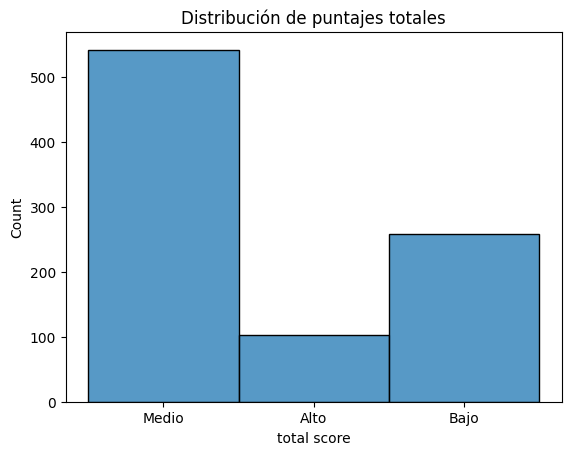

In [617]:
# Conteo de puntajes en histograma
sns.histplot(df["total score"], bins=3) 
plt.title("Distribución de puntajes totales")

<Axes: xlabel='total score', ylabel='Count'>

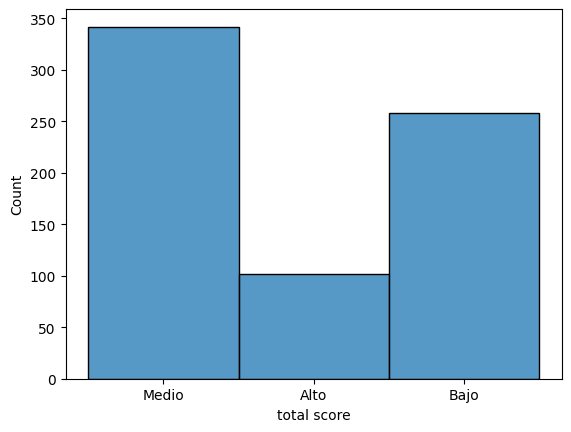

In [618]:
# Para que nuestro modelo no se sesgue, eliminaremos 200 filas aleatorias de la clase "Medio"
df.drop(df[df["total score"] == "Medio"].sample(200).index, inplace=True)
# Verificamos la distribución de los datos
sns.histplot(df["total score"], bins=3) 

### Encoding de variables categóricas

In [619]:
# Ordinal encoding para la caracteristica "parental level of education" y race/ethnicity 
parental_level_mapping = {
    "some high school": 0,
    "high school": 1,
    "some college": 2,
    "associate's degree": 3,
    "bachelor's degree": 4,
    "master's degree": 5
}
df["parental level of education"] = df["parental level of education"].map(parental_level_mapping)

race_mapping = {
    "group A": 0,
    "group B": 1,
    "group C": 2,
    "group D": 3,
    "group E": 4,
}
df["race/ethnicity"] = df["race/ethnicity"].map(race_mapping)

# Assignación booleana para gender, lunch y test preparation course
gender_mapping = {
    "female": 1,
    "male": 0
}
df["gender"] = df["gender"].map(gender_mapping)

lunch_mapping = {
    "standard": 1,
    "free/reduced": 0
}
df["lunch"] = df["lunch"].map(lunch_mapping)

test_preparation_mapping = {
    "completed": 1,
    "none": 0
}
df["test preparation course"] = df["test preparation course"].map(test_preparation_mapping)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,total score
0,1,1,4,1,0,72.0,72,Medio
2,1,1,5,1,0,90.0,95,Alto
3,0,0,3,0,0,47.0,57,Bajo
5,1,1,3,1,0,71.0,83,Medio
6,1,1,2,1,1,88.0,95,Alto


In [620]:
# Aplicar minMax scaler a las columnas numéricas math score y reading score, 
# pues queremos reducir su impacto para que el modelo le de igual importancia 
# a las variables socioeducativas
scaler = MinMaxScaler()
df[["math score", "reading score"]] = scaler.fit_transform(df[["math score", "reading score"]])
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,total score
0,1,1,4,1,0,0.695652,0.636364,Medio
2,1,1,5,1,0,0.891304,0.935065,Alto
3,0,0,3,0,0,0.423913,0.441558,Bajo
5,1,1,3,1,0,0.684783,0.779221,Medio
6,1,1,2,1,1,0.869565,0.935065,Alto


In [621]:
# Dividir en X e y
X = df.drop(columns=["total score"])
y = df["total score"]